In [2]:
import os
import perspectivemap as pm
import cv2
from PIL import Image
import numpy as np

raw = cv2.cvtColor(cv2.imread("C:/Users/ssuub/Desktop/Calibration Test.bmp"),  cv2.COLOR_RGB2BGR)

# IMDIMS = (376,300)
# CHIP_BOTTOMLEFT = (719, 757)
# CHIP_TOPRIGHT = (315, 109)

IMDIMS = (4000,3000)
CHIP_BOTTOMLEFT = (719, 757)
CHIP_TOPRIGHT = (315, 109)

mintemp = 10
maxtemp = 70



# raw[CHIP_TOPRIGHT[1] - 5:CHIP_TOPRIGHT[1] + 5,
#     CHIP_TOPRIGHT[0] - 5:CHIP_TOPRIGHT[0] + 5] = [0, 255, 0]

# raw[CHIP_BOTTOMLEFT[1] - 5:CHIP_BOTTOMLEFT[1] + 6,
#     CHIP_BOTTOMLEFT[0] - 5:CHIP_BOTTOMLEFT[0] + 6] = [255, 0, 0]


pm.refresh_reference()
transform = pm.image_transform
converted_img = cv2.warpPerspective(
    raw, transform, IMDIMS, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
# coords_y, coords_x = np.indices(np.shape(converted_img))

print(converted_img)
print(type(converted_img))
print(converted_img.shape)
# img = Image.fromarray(converted_img)
# img.show()

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
<class 'numpy.ndarray'>
(3000, 4000, 3)


In [3]:
from pylab import *

def color_temp(temperature, min, max, cmap = 'magma'):
    # Returns an RGB tuple corresponding to the temperature value
    color = matplotlib.colormaps.get_cmap(cmap)
    progress = (temperature - min) / (max - min)
    color_val = color(int(progress * 255))
    return (int(color_val[0] * 255), int(color_val[1] * 255), int(color_val[2] * 255))

In [ ]:
import csv

with open("C:/Users/ssuub/Desktop/EDET80k_Damage/Lasing Analysis/apps/Simulation and BeamLib/Caleb/New PC Data/tl-resist.csv", newline='') as csvfile:
    block_tl = np.array(list(csv.reader(csvfile, delimiter=';')))
with open("C:/Users/ssuub/Desktop/EDET80k_Damage/Lasing Analysis/apps/Simulation and BeamLib/Caleb/New PC Data/bl-resist2.csv", newline='') as csvfile:
    block_bl = np.array(list(csv.reader(csvfile, delimiter=';')))
with open("C:/Users/ssuub/Desktop/EDET80k_Damage/Lasing Analysis/apps/Simulation and BeamLib/Caleb/New PC Data/tr-resist.csv", newline='') as csvfile:
    block_tr = np.array(list(csv.reader(csvfile, delimiter=';')))
with open("C:/Users/ssuub/Desktop/EDET80k_Damage/Lasing Analysis/apps/Simulation and BeamLib/Caleb/New PC Data/br-resist.csv", newline='') as csvfile:
    block_br = np.array(list(csv.reader(csvfile, delimiter=';')))

raw = block_tl
KELVIN_OFFSET = 273.15

# Format data into floats, then replace with intensity
intensityData = np.zeros((len(raw), len(raw[0]) - 1), dtype = np.float64)

for x in range(len(raw)):
    for y in range(len(raw[0]) - 1):
        intensityData[x,y] = (float(raw[x,y].replace(',', '.')) + KELVIN_OFFSET) ** 4

# Correct intensity values for perspective

IMDIMS = (400,300)

pm.refresh_reference()
transform = pm.image_transform
converted_img = cv2.warpPerspective(
    intensityData, transform, IMDIMS, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

imageData = np.zeros((len(converted_img), len(converted_img[0]) - 1, 3), dtype = np.uint8)

for x in range(len(converted_img)):
    for y in range(len(converted_img[0]) - 1):
        imageData[x,y] = color_temp((converted_img[x,y] ** 0.25) - KELVIN_OFFSET, 25, 70)



img = Image.fromarray(imageData)
img.show()

In [ ]:
from rich.progress import Progress
from rich.console import Console


filepath = "C:/Users/ssuub/Desktop/EDET80k_Damage/Lasing Analysis/apps/Simulation and BeamLib/Caleb/New PC Data/br-resist.csv"
KELVIN_OFFSET = 273.15
WIDTH, HEIGHT, SCALING = pm.get_calibration_dimensions()

def imageCorrect(filename, mintemp = 25, maxtemp = 70):
    with open(filename, newline='') as csvfile:
        raw = np.array(list(csv.reader(csvfile, delimiter=';')))

    # Format data into floats, then replace with intensity
    intensity_data = np.zeros((len(raw), len(raw[0]) - 1), dtype = np.float64)

    for x in range(len(raw)):
        for y in range(len(raw[0]) - 1):
            intensity_data[x,y] = (float(raw[x,y].replace(',', '.')) + KELVIN_OFFSET) ** 4

    
    
    # Correct intensity values for perspective
    pm.refresh_reference()
    transform = pm.image_transform
    with Progress(console=Console(force_terminal=True, force_jupyter=False)) as progress:
        task = progress.add_task("Correcting Image Distortion...", total=1)
        spacial_corrected = cv2.warpPerspective(
            intensityData, transform, IMDIMS, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        progress.update(task, advance=1)
    
    # Account for Lambertian Emission and Occlusion
    

    
    
    # Map to color scale
    with Progress(console=Console(force_terminal=True, force_jupyter=False)) as progress:
        task = progress.add_task("Mapping to Color Scale...", total = len(spacial_corrected) * (len(spacial_corrected[0]) - 1))
        imageData = np.zeros((len(spacial_corrected), len(spacial_corrected[0]) - 1, 3), dtype = np.uint8)

        for x in range(len(spacial_corrected)):
            for y in range(len(spacial_corrected[0]) - 1):
                imageData[x,y] = color_temp((spacial_corrected[x,y] ** 0.25) - KELVIN_OFFSET, mintemp, maxtemp)
                progress.update(task, advance=1)
    
    img = Image.fromarray(imageData)
    img.show()
    
    
imageCorrect(filepath)




Correcting Image Distortion... ----------------------------------- 100% 0:00:00
Mapping to Color Scale... ---------------------------------------- 100% 0:00:0000:0100:01


Estimated Runtime: 0:05:35
(288, 383)
Correcting Image Distortion... ----------------------------------- 100% 0:00:00
Correcting for Angle Dependence... ------------------------------- 100% 0:00:0000:0100:10
Mapping to Color Scale... ---------------------------------------- 100% 0:00:0000:0100:01


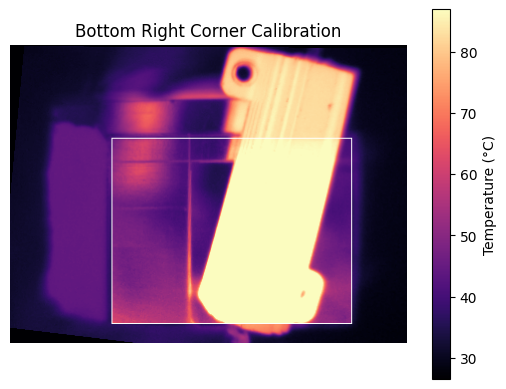

In [ ]:
import anglemap as am

filepath = "C:/Users/ssuub/Desktop/EDET80k_Damage/Lasing Analysis/apps/Simulation and BeamLib/Caleb/New PC Data/tr-resist.csv"

am.imageCorrect(filepath, 
                title = "Bottom Right Corner Calibration", 
                roi = "brick", 
                correction_resolution = 10)

Estimated Runtime: 2:07:16
Correcting Image Distortion... ----------------------------------- 100% 0:00:00
Correcting for Angle Dependence... ------------------------------- 100% 0:00:0000:0100:21
Mapping to Color Scale... ---------------------------------------- 100% 0:00:0000:0100:01


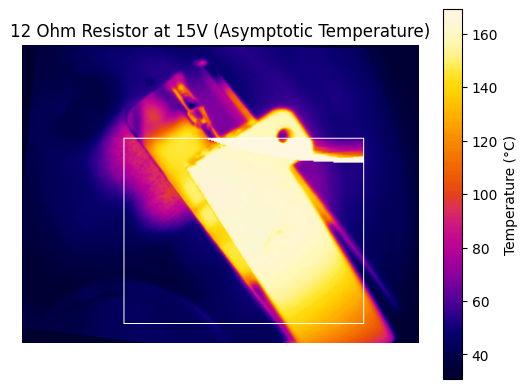

In [ ]:
import anglemap as am

filepath = "C:/Users/ssuub/Desktop/EDET80k_Damage/Lasing Analysis/apps/Simulation and BeamLib/Caleb/New PC Data/Gradient-15V.csv"


am.imageCorrect(filepath, 
                title = "12 Ohm Resistor at 15V (Asymptotic Temperature)", 
                roi = "brick", 
                correction_resolution = 30,
                quadratic = False)

Estimated Runtime: 0:05:35
Correcting Image Distortion... ----------------------------------- 100% 0:00:00
Correcting for Angle Dependence... ------------------------------- 100% 0:00:0000:0100:10
Mapping to Color Scale... ---------------------------------------- 100% 0:00:00m 0:00:01


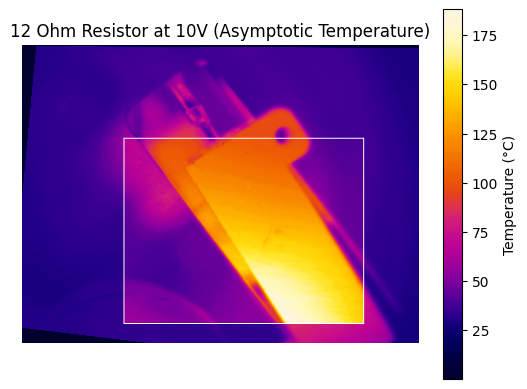

In [2]:
import anglemap as am

filepath = "C:/Users/ssuub/Desktop/EDET80k_Damage/Lasing Analysis/apps/Simulation and BeamLib/Caleb/New PC Data/Gradient-10V.csv"

am.imageCorrect(filepath, 
                title = "12 Ohm Resistor at 10V (Asymptotic Temperature)", 
                roi = "brick",
                correction_resolution = 10)

Estimated Runtime: 0:00:22
Correcting Image Distortion... ----------------------------------- 100% 0:00:00
Correcting for Angle Dependence... ------------------------------- 100% 0:00:00m -:--:--
Mapping to Color Scale... ---------------------------------------- 100% 0:00:00m 0:00:01


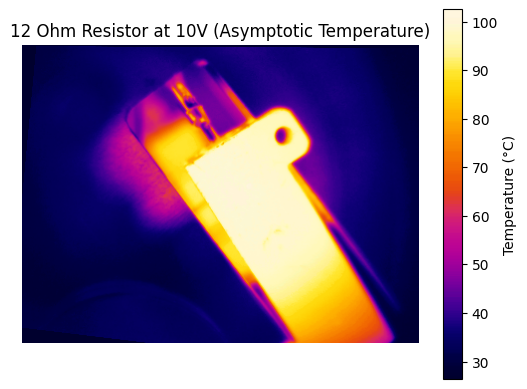

In [7]:
am.imageCorrect(filepath, 
                title = "12 Ohm Resistor at 10V (Asymptotic Temperature)", 
                correction_resolution = 5,
                lambertian = False,
                occlusion = False)

Estimated Runtime: 0:00:26
Correcting Image Distortion... ----------------------------------- 100% 0:00:00
Correcting for Angle Dependence... ------------------------------- 100% 0:00:0000:0100:01
Mapping to Color Scale... ---------------------------------------- 100% 0:00:0000:0100:01


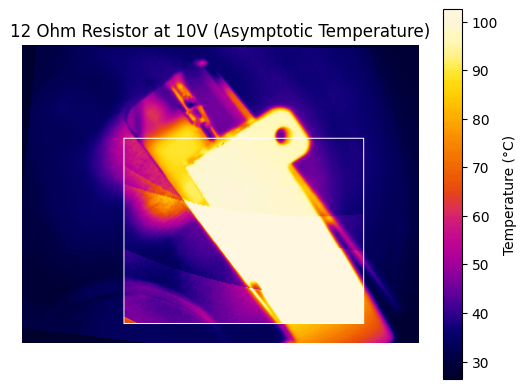

In [6]:
am.imageCorrect(filepath, 
                title = "12 Ohm Resistor at 10V (Asymptotic Temperature)", 
                roi = "brick", 
                correction_resolution = 2,
                lambertian = False)

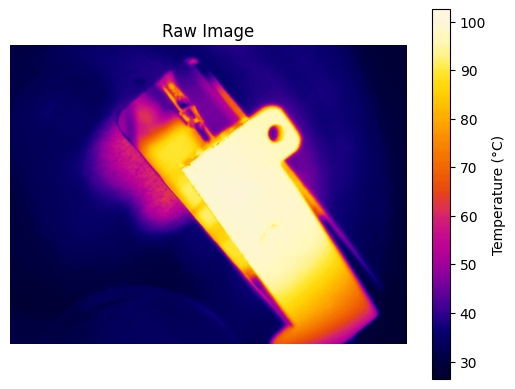

In [3]:
import anglemap as am

filepath = "C:/Users/ssuub/Desktop/EDET80k_Damage/Lasing Analysis/apps/Simulation and BeamLib/Caleb/New PC Data/Gradient-10V.csv"

am.renderImage(filepath,
               title = "Raw Image",
               cmap = 'iron')